## Import Packages

In [1]:
import os
from math import pi

import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from scipy import spatial

from labvision import images, video
import filehandling
from particletracking import dataframes, statistics

/home/ppxjd3/.local/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Get the first frame from each video

In [2]:
main_directory = filehandling.open_directory()
frame_directory = f"{main_directory}/first_frames"

In [58]:
def get_crop_and_mask(im):
    if not os.path.isfile(f"{main_directory}/crop.txt"):
        crop_result = images.crop_polygon(im)
        crop = np.array(crop_result.bbox.to_tuple())
        mask = np.array(crop_result.mask)
        print(bbox)
        print(mask)
        np.savetxt(f"{main_directory}/crop.txt", crop)
        np.savetxt(f"{main_directory}/mask.txt", mask)
    else:
        crop = np.loadtxt(f"{main_directory}/crop.txt", dtype=np.uint16)
        crop = images.BBox(crop[0, 0], crop[1, 0], crop[0, 1], crop[1, 1])
        mask = np.loadtxt(f"{main_directory}/mask.txt", dtype=np.uint8)
    return crop, mask

In [61]:
def create_single_frames(main_directory, frame_directory):
    if os.path.isdir(frame_directory):
        print("Directory exists")
    else:
        os.mkdir(frame_directory)

    vid_files = filehandling.get_directory_filenames(f"{main_directory}/*.MP4")
    frame_files = filehandling.get_directory_filenames(f"{frame_directory}/*.png")

    if len(frame_files) < len(vid_files):
        for vid_file in vid_files:
            direc, vid_file = os.path.split(vid_file)
            vid_name, _ = os.path.splitext(vid_file)
            if os.path.isfile(f"{frame_directory}/{vid_name}.png"):
                print(f"{vid_name}.png already exists")
            else:
                vid = video.ReadVideo(f"{direc}/{vid_file}")
                frame = vid.read_next_frame()
                crop, mask = get_crop_and_mask(frame)
#                 print(crop.xmin, crop.xmax, crop.ymin, crop.ymax)
                frame = images.crop_and_mask(frame, crop, mask)
                images.save(frame, f"{frame_directory}/{vid_name}.png")

In [62]:
create_single_frames(main_directory, frame_directory)

Directory exists


## Find Circles in each image

In [3]:
def get_images(frame_directory):
    image_files = filehandling.get_directory_filenames(f"{frame_directory}/*.png")
    ims = [images.load(f) for f in image_files]
    return ims
ims = get_images(frame_directory)

In [95]:
%matplotlib auto
def find_circles(ims):
    gray = [images.bgr_to_gray(im.copy()) for im in ims]
    circles = [images.find_circles(g, 25, 255, 7, 17, 19) 
               for g in gray]
    return circles

def create_data(dataname, ims, force_new=False):
    if os.path.isfile(dataname):
        data = dataframes.DataStore(dataname)
    else:
        data = dataframes.DataStore(dataname, load=False)
        circles = find_circles(ims)
        for f, info in tqdm(enumerate(circles), 'Adding Circles'):
            data.add_tracking_data(f, info, ['x', 'y', 'r'])

        calc = statistics.PropertyCalculator(data)
        calc.order()
        data.save()
    return data

data = create_data(f"{frame_directory}/first_frame_data.hdf5", ims)

Using matplotlib backend: Qt5Agg


## Get radius

In [100]:
RADIUS = data.df.loc[0].r.mean()
RADIUS

18.235775

## Calculate fields 

In [513]:
def coarse_order_field(df, cgw, x, y, no_of_neighbours=20):
    """
    Calculate the coarse-grained field characterising local orientation order
    """

    order = df.order.values

    # Generate the lattice nodes to query
    # x, y = np.meshgrid(x, y)
    r = np.dstack((x, y))

    # Get the positions of all the particles
    particles = df[['x', 'y']].values

    # Generate the tree from the particles
    tree = spatial.cKDTree(particles)

    # Query the tree at all the lattice nodes to find the nearest n particles
    # Set n_jobs=-1 to use all cores
    dists, indices = tree.query(r, no_of_neighbours, n_jobs=-1)

    # Calculate all the coarse-grained delta functions (Katira ArXiv eqn 3
    cg_deltas = np.exp(-dists ** 2 / (2 * cgw ** 2)) / (2 * pi * cgw ** 2)

    # Multiply by the orders to get the summands
    summands = cg_deltas * order[indices]

    # Sum along axis 2 to calculate the field
    field = np.sum(summands, axis=2)

    return field

def calculate_fields(data, cgw, x, y, N=None):
    if N is None:
        N = len(ims)
    return [coarse_order_field(data.df.loc[f], cgw, x, y)
           for f in tqdm(range(N), 'Calculating Fields')]

In [494]:
lattice_spacing = 10
x = np.arange(0, ims[0].shape[1], lattice_spacing)
y = np.arange(0, ims[0].shape[0], lattice_spacing)
x, y = np.meshgrid(x, y)

In [332]:
cgw = RADIUS * 4

In [116]:
fields = calculate_fields(data, cgw, x, y)

In [139]:
%matplotlib auto
plt.imshow(fields[0])

Using matplotlib backend: Qt5Agg


## Calculate the field threshold
Ordered particles on the left

Disordered particles on the right

In [148]:
def calculate_field_threshold(fields):
    phi_o, phi_d = zip(*[(np.mean(f[:, 60:80]), np.mean(f[:, 155:175])) for f in fields])
    phi_o = np.mean(phi_o)
    phi_d = np.mean(phi_d)
    return (phi_o + phi_d) / 2
field_threshold = calculate_field_threshold(fields)
print(f"field_threshold = {field_threshold}")

field_threshold = 0.0003055455731859019


## Use the field threshold to find the boundary

In [542]:
def get_contour(f, t):
    im = np.uint8(f < t)
    im[:5, :] = 1
    im[-5:, :] = 1
    im[:, :5] = 1
    im[:, -5:] = 1
    cs = images.find_contours(im)
    cs = images.sort_contours(cs)
    return cs[-2] # -1 is a box around the whole image

def get_contours(fields, t):
    contours = [get_contour(f, t) for f in fields]
    return contours

In [276]:
contours = get_contours(fields, field_threshold)

# Multiply the contours by the lattice constant
contours = [c * lattice_spacing for c in contours]

## Use the boundary to find the heights 

In [199]:
from shapely.geometry import LineString

In [505]:
def get_x(i):
    if i.geom_type == 'Point':
        return i.x
    elif i.geom_type == 'LineString':
        return np.array(i.coords[:])[:, 0].mean()

def get_heights(c):
    X0 = 120*lattice_spacing
    c_ls = LineString(c.squeeze())
    dxs = []
    points = []
    for row in range(10*lattice_spacing, 190*lattice_spacing):
        l = LineString(((0, row), (201*lattice_spacing, row)))
        intersections = l.intersection(c_ls)
        try:
            xs = [get_x(i) for i in intersections]
            dx = [x - X0 for x in xs]
            argmin = np.argmin(np.abs(dx))
            dx = dx[argmin]
            points.append((xs[argmin], row))
            dxs.append(dx)
        except TypeError as e:
            if intersections.geom_type == 'LineString':
                if not intersections.is_empty:
                    x_mean = np.array(intersections.coords[:])[:, 0].mean()
                else:
                    x_mean = X0
                
                points.append((x_mean, row))
                dxs.append(x_mean - X0)
            elif intersections.geom_type == 'Point':
                x = intersections.x
                points.append((x, row))
                dxs.append(x - X0)
            
    return dxs, points

def get_all_heights(contours):
    heights, points = zip(*[get_heights(c) for c in tqdm(contours, 'Finding heights')])
    
    return np.array(heights), np.array(points)

In [493]:
heights, boundaries = get_all_heights(contours)

(343, 1, 2)
(344, 1, 2)
(411, 1, 2)
(307, 1, 2)
(328, 1, 2)


KeyboardInterrupt: 

## Plot the average boundary

In [282]:
boundaries.shape

(100, 1800, 2)

In [283]:
average_boundary = np.mean(boundaries, axis=0)
spread_boundary = np.std(boundaries, axis=0)

In [284]:
plt.imshow(ims[0])
plt.errorbar(average_boundary[:, 0], average_boundary[:, 1], 
             xerr=spread_boundary[:, 0], yerr=spread_boundary[:, 1])

<ErrorbarContainer object of 3 artists>

## Convert units from pixels to mm
Use the distance between red faces, the image height(199mm)

In [59]:
height_pixels = ims[0].shape[0]
height_mm = 199.0
pixels_to_mm = height_mm / height_pixels

In [58]:
heights_mm = [h * pixels_to_mm for h in heights]
boundaries_mm = boundaries * pixels_to_mm
cgw_mm = cgw * pixels_to_mm
radius_mm = RADIUS * pixels_to_mm

NameError: name 'heights' is not defined

In [9]:
def convert_pix_to_mm(heights, boundaries, cgw, radius):
    height_pixels = ims[0].shape[0]
    height_mm = 199.0
    pixels_to_mm = height_mm / height_pixels

    heights_mm = [h * pixels_to_mm for h in heights]
    boundaries_mm = boundaries * pixels_to_mm
    cgw_mm = cgw * pixels_to_mm
    radius_mm = radius * pixels_to_mm
    return heights_mm, boundaries_mm, cgw_mm, radius_mm

## Plot the fourier transform

In [21]:
def get_plot_values(heights, dx):
    N = len(heights[0])
    L = dx * N
    
    fourier = [np.abs(np.fft.fft(h))**2 for h in heights]
    y = np.stack(fourier)[:, 1:N//2] * L
    freq = np.fft.fftfreq(N, dx)[1:N//2]
    
    y_mean = np.mean(y, axis=0).squeeze()
    y_err = np.std(y, axis=0, ddof=1).squeeze()
    
    x = freq * 2 * np.pi
    
    xplot = np.log10(x)
    yplot = np.log10(y_mean)
    yerr = 0.434 * y_err / y_mean
    return xplot, yplot, yerr

def get_fit(x, y, yerr):
    fit, fit_err = np.polyfit(x, y, 1, w=1/(yerr*yerr), cov=True)
    return fit, np.sqrt(np.diag(fit_err))

def plot_fft(heights, dL, dL_min, cgw, L, ax=None, return_fit=False, mmin=1):
    
    xplot, yplot, yerr = get_plot_values(heights, dL)
    
    xmax = sum(xplot < np.log10(2*pi/dL_min))
    xplot = xplot[mmin:xmax]
    xplot = np.log10(np.arange(mmin, xmax)**2-1)
    yplot = yplot[mmin:xmax]
    yerr = yerr[mmin:xmax]
    
    fit, fit_err = get_fit(xplot, yplot, yerr)
    
    if return_fit:
        return fit, fit_err
    
    if ax is None:
        fig, ax = plt.subplots()
    
    ax.plot(xplot, xplot*fit[0]+fit[1], 
             label=f"Fit (gradient = {fit[0]:.2f}+/-{fit_err[0]:.2f}))")
    ax.errorbar(xplot, yplot, yerr)
    
    ax.axvline(np.log10(2*pi/L), label='L', c='r')
    ax.axvline(np.log10(2*pi/cgw), label='cgw', c='g')
    
    
    ax.legend()
#     ax.set_title(f"cgw = {cgw:.2f} mm")
    ax.set_xlabel('log$_{10}(k = 2\pi m/L)$ [mm$^{-1}$]')
    ax.set_ylabel('log$_{10}(<|\delta h_k|^2>L)$ [mm$^3$]')

In [356]:
dL_mm = boundaries_mm[0, 1, 1] - boundaries_mm[0, 0, 1]
L_mm = dL_mm * boundaries.shape[1]

In [375]:
plot_fft(heights_mm, dL_mm, cgw_mm, cgw_mm, L_mm)

## Compare the results for different cgws

In [598]:
def compare_cgws(data, data_dir, cs):
#     cgws = [c * RADIUS for c in [1, 5, 10, 20]]
#     cs = np.logspace(0.1, 50, 20)
#     fig, ax = plt.subplots(4, 4)
#     cs = [1, 5]

    if not os.path.isdir(data_dir):
        os.mkdir(data_dir)
    for i, c in enumerate(cs):
        print(i)
        cgw = c * RADIUS
        if os.path.isfile(f"{data_dir}/{c}_fields.npy"):
            continue
        try:
            fields = calculate_fields(data, cgw, x, y)
    #         ax[0, i].imshow(fields[0])
            field_threshold = calculate_field_threshold(fields)
    #         ax[1, i].imshow(fields[0]<field_threshold)


            contours = get_contours(fields, field_threshold)
            # Multiply the contours by the lattice constant
            contours = [c * lattice_spacing for c in contours]

            np.save(f"{data_dir}/{c}_fields.npy", fields)
            np.save(f"{data_dir}/{c}_field_threshold.npy", field_threshold)
            np.save(f"{data_dir}/{c}_contours.npy", contours)


    #         ax[2, i].imshow(ims[0])
    #         ax[2, i].plot(contours[0][:, :, 0], contours[0][:, :, 1], 'r')



            heights, boundaries = get_all_heights(contours)
            heights_mm, boundaries_mm, cgw_mm, radius_mm = \
                convert_pix_to_mm(heights, boundaries, cgw, RADIUS)

            np.save(f"{data_dir}/{c}_heights_mm.npy", heights_mm)
            np.save(f"{data_dir}/{c}_boundaries_mm.npy", boundaries_mm)
            np.save(f"{data_dir}/{c}_cgw_mm.npy", cgw_mm)

    #         plot_fft(heights_mm, dL_mm, cgw_mm, cgw_mm, L_mm, ax=ax[3, i])
        except Exception as e:
            print(e)
            print(f"The value c = {c} failed")


## Use saved data from file

In [7]:
def load_and_compare_cgw(data_dir, subtract_mean=False, cs=None, mmin=1):
    
    if cs is None:
        files = filehandling.get_directory_filenames(data_dir+'/*')
        names = [os.path.split(f)[1] for f in files]
        cs = list(set([n.split('_')[0] for n in names]))
        cs_sort = np.argsort([float(c) for c in cs])
        cs = np.array(cs)[cs_sort]   
    
    
    for i, c in enumerate(cs):
        fig, ax = plt.subplots(2, 2)
        fields = np.load(f"{data_dir}/{c}_fields.npy")
        field_threshold = np.load(f"{data_dir}/{c}_field_threshold.npy")
        contours = np.load(f"{data_dir}/{c}_contours.npy", allow_pickle=True)
        heights_mm = np.load(f"{data_dir}/{c}_heights_mm.npy")
        boundaries_mm = np.load(f"{data_dir}/{c}_boundaries_mm.npy")
        cgw_mm = np.load(f"{data_dir}/{c}_cgw_mm.npy")
        
        
        if subtract_mean:
            heights_mean = np.mean(heights_mm, axis=0)
            heights_mm = heights_mm - heights_mean
        
        ax[0, 0].imshow(fields[0, :, :])
        ax[0, 0].set_title(f"cgw = {cgw_mm} mm")
        ax[0, 1].imshow(fields[0, :, :]<field_threshold)
        ax[1, 0].imshow(ims[0])
        ax[1, 0].plot(contours[0][:, :, 0], contours[0][:, :, 1])
        ax[1, 0].plot(boundaries_mm[0, :, 0]/pixels_to_mm, boundaries_mm[0, :, 1]/pixels_to_mm)
        dL_mm = boundaries_mm[0, 1, 1] - boundaries_mm[0, 0, 1]
        L_mm = dL_mm * boundaries_mm.shape[1]
        plot_fft(heights_mm, dL_mm, cgw_mm, cgw_mm, L_mm, ax=ax[1, 1], mmin=mmin)
    

In [17]:
def gradient_against_cgw(data_dir, subtract_average=False, mmin=1):
    files = filehandling.get_directory_filenames(data_dir+'/*')
    names = [os.path.split(f)[1] for f in files]
    cs = list(set([n.split('_')[0] for n in names]))
    cs_sort = np.argsort([float(c) for c in cs])
    cs = np.array(cs)[cs_sort]
    cgws = []
    grads = []
    grad_errs = []
    for i, c in enumerate(cs):
        fields = np.load(f"{data_dir}/{c}_fields.npy")
        field_threshold = np.load(f"{data_dir}/{c}_field_threshold.npy")
        contours = np.load(f"{data_dir}/{c}_contours.npy", allow_pickle=True)
        heights_mm = np.load(f"{data_dir}/{c}_heights_mm.npy")
        boundaries_mm = np.load(f"{data_dir}/{c}_boundaries_mm.npy")
        cgw_mm = np.load(f"{data_dir}/{c}_cgw_mm.npy")
        
        if cgw_mm > 20:
            continue
        
        if subtract_average:
            heights_mean = np.mean(heights_mm, axis=0)
            heights_mm = heights_mm - heights_mean
        
        dL_mm = boundaries_mm[0, 1, 1] - boundaries_mm[0, 0, 1]
        L_mm = dL_mm * boundaries_mm.shape[1]
        
        if cgw_mm < 2:
            continue
        
        try:
            fit, fit_err = plot_fft(heights_mm, dL_mm, cgw_mm, cgw_mm, L_mm, return_fit=True, mmin=mmin)
            cgws.append(cgw_mm)
            grads.append(fit[0])
            grad_errs.append(fit_err[0])
        except:
            print(f"For cgw = {cgw_mm}. Fit Failed")
        
#     plt.figure()
    plt.errorbar(cgws, grads, yerr=grad_errs, fmt='x')
    plt.xlabel('cgw (mm)')
    plt.ylabel('Fit')
    
#     plt.figure()
#     plt.errorbar(cgws, grads, yerr=grad_errs, fmt='x')
#     ax = plt.gca()
#     ax.set_xscale('log')
#     plt.xlabel('cgw (mm)')
#     plt.ylabel('Fit')
    

In [143]:
def plot_mean_boundary(data_dir, cs=None):
    figure_dir = "/media/data/Data/FirstOrder/Interfaces/RecordingFluctuationsOctober2020/Figures/mean_boundaries"
    
    if cs is None:
        files = filehandling.get_directory_filenames(data_dir+'/*')
        names = [os.path.split(f)[1] for f in files]
        cs = list(set([n.split('_')[0] for n in names]))
        cs_sort = np.argsort([float(c) for c in cs])
        cs = np.array(cs)[cs_sort]
    cgws = []
    grads = []
    grad_errs = []
    for i, c in enumerate(cs):
        boundaries_mm = np.load(f"{data_dir}/{c}_boundaries_mm.npy")
        mean_boundary = np.mean(boundaries_mm, axis=0) / pixels_to_mm
        
        plt.figure()
        plt.imshow(ims[0])
        plt.plot(mean_boundary[:, 0], mean_boundary[:, 1])
        plt.savefig(f"{figure_dir}/{c}.png")
        

In [5]:
data_dir = f"{main_directory}/data"
data_dir

'/media/data/Data/FirstOrder/Interfaces/RecordingFluctuationsOctober2020/data'

In [599]:
compare_cgws(data, data_dir, cs)

0



1



2



3



4



5



6



7



8



9



10



11



12



13



14



15



16



17



18



19



20



21



22



23



24



25



26



27



28



29



30



31



32



33



34



35



36



37



38



39



40



41



42



43



44



45



46



47



48



49


In [11]:
pixels_to_mm = 200/ims[0].shape[0]

In [22]:
%matplotlib auto
load_and_compare_cgw(data_dir, subtract_mean=True, cs=['1.1', '2.22', '4.5', '7.91'], mmin=3)

Using matplotlib backend: Qt5Agg


In [18]:
%matplotlib auto
gradient_against_cgw(data_dir, subtract_average=True, mmin=2)
gradient_against_cgw(data_dir, subtract_average=False, mmin=2)
plt.legend(['From Average', 'From Flat'])

Using matplotlib backend: Qt5Agg


In [23]:
plt.close('all')

In [65]:
plt.rcParams.update({'figure.max_open_warning': 0})

In [76]:
plot_mean_boundary(data_dir)

In [180]:
def four_plots(data_dir, subtract_mean=False, cs=None, mmin=1): 
    
    # Fields
    fig, ax = plt.subplots(2, 2)
    for i, c in enumerate(cs):
        fields = np.load(f"{data_dir}/{c}_fields.npy")
        cgw_mm = np.load(f"{data_dir}/{c}_cgw_mm.npy")
        ax[i//2, i%2].imshow(fields[0, :, :])
        ax[i//2, i%2].set_title(f"cgw = {cgw_mm:.2f} mm")
        
    # ThresholdedFields
    fig, ax = plt.subplots(2, 2)
    for i, c in enumerate(cs):
        fields = np.load(f"{data_dir}/{c}_fields.npy")
        cgw_mm = np.load(f"{data_dir}/{c}_cgw_mm.npy")
        field_threshold = np.load(f"{data_dir}/{c}_field_threshold.npy")
        ax[i//2, i%2].imshow(fields[0, :, :] < field_threshold)
        ax[i//2, i%2].set_title(f"cgw = {cgw_mm:.2f} mm")
        
    
    # Contours 
    fig, ax = plt.subplots(2, 2)
    for i, c in enumerate(cs):
        fields = np.load(f"{data_dir}/{c}_fields.npy")
        cgw_mm = np.load(f"{data_dir}/{c}_cgw_mm.npy")
        contours = np.load(f"{data_dir}/{c}_contours.npy", allow_pickle=True)
        heights_mm = np.load(f"{data_dir}/{c}_heights_mm.npy")
        boundaries_mm = np.load(f"{data_dir}/{c}_boundaries_mm.npy")
        
        ax[i//2, i%2].imshow(ims[0])
        ax[i//2, i%2].plot(contours[0][:, :, 0], contours[0][:, :, 1])
        ax[i//2, i%2].plot(boundaries_mm[0, :, 0]/pixels_to_mm, boundaries_mm[0, :, 1]/pixels_to_mm)
        ax[i//2, i%2].set_title(f"cgw = {cgw_mm:.2f} mm")
        

    # Plots
    fig, ax = plt.subplots(2, 2)
    for i, c in enumerate(cs):
        cgw_mm = np.load(f"{data_dir}/{c}_cgw_mm.npy")
        heights_mm = np.load(f"{data_dir}/{c}_heights_mm.npy")
        boundaries_mm = np.load(f"{data_dir}/{c}_boundaries_mm.npy")
        dL_mm = boundaries_mm[0, 1, 1] - boundaries_mm[0, 0, 1]
        L_mm = dL_mm * boundaries_mm.shape[1]
        plot_fft(heights_mm, dL_mm, cgw_mm, cgw_mm, L_mm, ax=ax[i//2, i%2], mmin=mmin)
        
        
#     for i, c in enumerate(cs):
#         fig, ax = plt.subplots(2, 2)
#         fields = np.load(f"{data_dir}/{c}_fields.npy")
#         field_threshold = np.load(f"{data_dir}/{c}_field_threshold.npy")
#         contours = np.load(f"{data_dir}/{c}_contours.npy", allow_pickle=True)
#         heights_mm = np.load(f"{data_dir}/{c}_heights_mm.npy")
#         boundaries_mm = np.load(f"{data_dir}/{c}_boundaries_mm.npy")
#         cgw_mm = np.load(f"{data_dir}/{c}_cgw_mm.npy")
        
        
#         if subtract_mean:
#             heights_mean = np.mean(heights_mm, axis=0)
#             heights_mm = heights_mm - heights_mean
        
#         ax[0, 0].imshow(fields[0, :, :])
#         ax[0, 0].set_title(f"cgw = {cgw_mm} mm")
#         ax[0, 1].imshow(fields[0, :, :]<field_threshold)
#         ax[1, 0].imshow(ims[0])
#         ax[1, 0].plot(contours[0][:, :, 0], contours[0][:, :, 1])
#         ax[1, 0].plot(boundaries_mm[0, :, 0]/pixels_to_mm, boundaries_mm[0, :, 1]/pixels_to_mm)
#         dL_mm = boundaries_mm[0, 1, 1] - boundaries_mm[0, 0, 1]
#         L_mm = dL_mm * boundaries_mm.shape[1]
#         plot_fft(heights_mm, dL_mm, cgw_mm, cgw_mm, L_mm, ax=ax[1, 1], mmin=mmin)
    

In [185]:
four_plots(data_dir, True, ['1.1', '2.22', '4.5', '7.91'], 2)

In [177]:
plt.close('all')

In [60]:
def new_plot_fft(heights, L, mmin=1, mmax=100, cgw=None):
    m = np.arange(mmin, mmax+1, 1)
    k = 2*pi*m / L
    
    R_k_squared_i = [np.abs(np.fft.rfft(h)**2) for h in heights]
    R_k_squared = np.mean(R_k_squared_i, axis=0)
    R_k_squared_std = np.std(R_k_squared_i, ddof=1, axis=0)
    
    x = np.log10(k)
    y = np.log10(R_k_squared[mmin:mmax+1]*L)
    dy = (0.434 * R_k_squared_std / R_k_squared)[mmin:mmax+1]
    
    fit, fit_err = np.polyfit(x, y, 1, w=1/(dy*dy), cov=True)
    fit_err = np.sqrt(np.diag(fit_err))
    
    fig, ax = plt.subplots()
    ax.errorbar(x, y, dy)
    ax.plot(x, x*fit[0]+fit[1])
    ax.axvline(np.log10(2*pi/cgw))
    
    return fit[0], fit_err[0]
    
    

5.333986900930211
mmax = 33


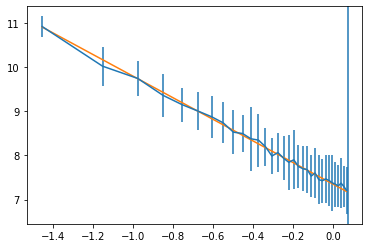

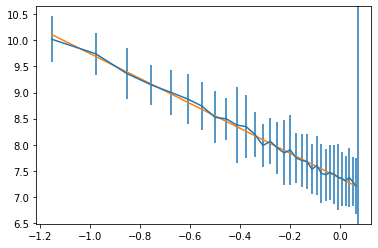

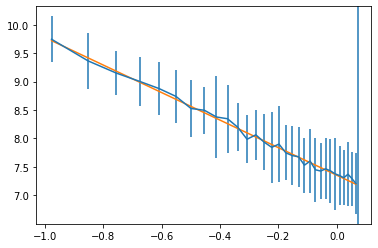

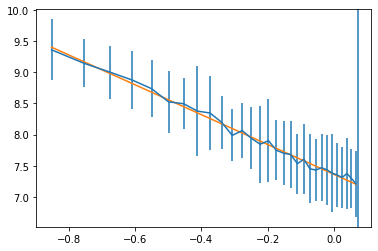

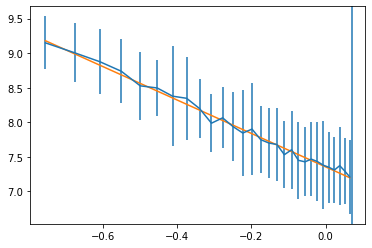

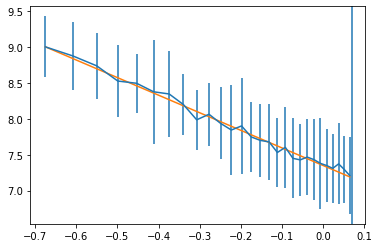

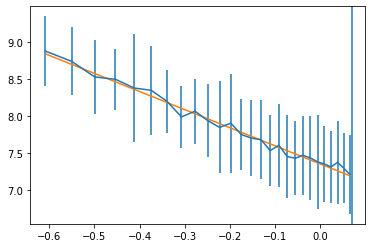

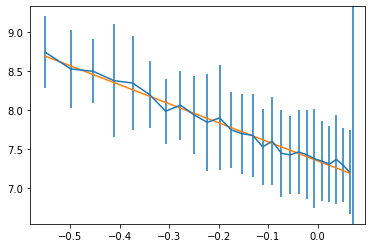

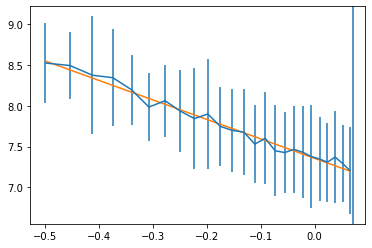

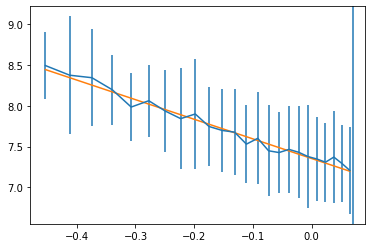

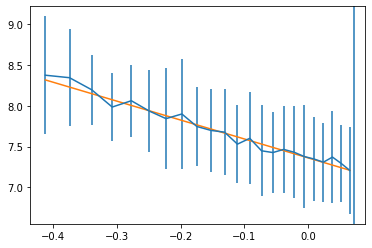

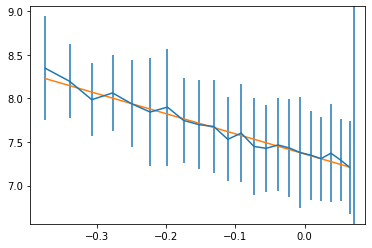

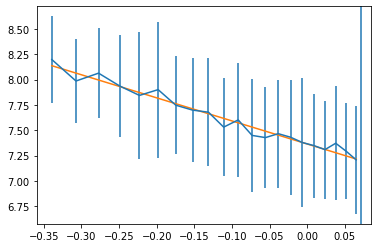

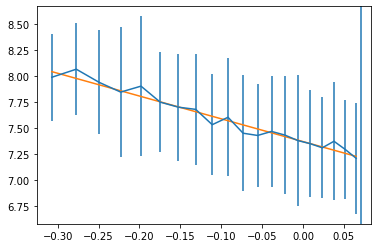

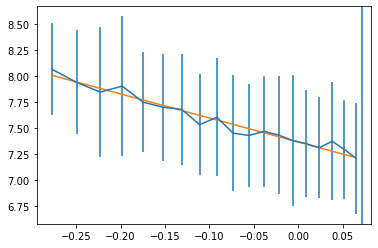

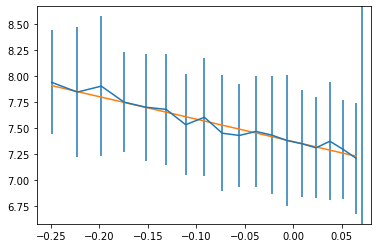

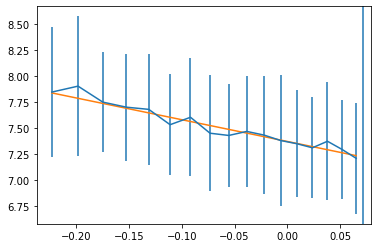

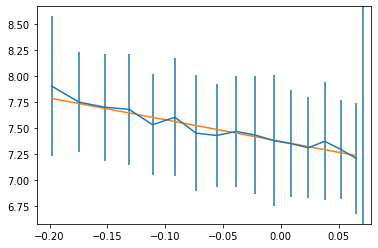

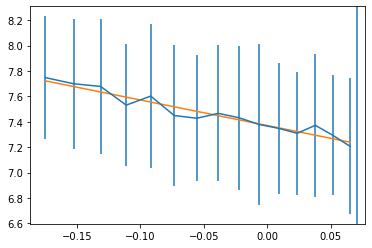

In [64]:
def compare_mmins(data_dir, c='2.95'):
    fields = np.load(f"{data_dir}/{c}_fields.npy")
    field_threshold = np.load(f"{data_dir}/{c}_field_threshold.npy")
    contours = np.load(f"{data_dir}/{c}_contours.npy", allow_pickle=True)
    heights_mm = np.load(f"{data_dir}/{c}_heights_mm.npy")
    boundaries_mm = np.load(f"{data_dir}/{c}_boundaries_mm.npy")
    cgw_mm = np.load(f"{data_dir}/{c}_cgw_mm.npy")
    print(cgw_mm)
    dL_mm = boundaries_mm[0, 1, 1] - boundaries_mm[0, 0, 1]
    L_mm = dL_mm * boundaries_mm.shape[1]
    mmins = np.arange(1, 20)
    mmax = int(L_mm / cgw_mm)
    print(f"mmax = {mmax}")
    fit, fit_err = zip(*[new_plot_fft(heights_mm, L_mm, mmin=m, mmax=mmax, cgw=cgw_mm) for m in mmins])
    return mmins, fits, fit_err
mmins, fits, fit_errs = compare_mmins(data_dir)

## Gradient changes with changing lower bound

<ErrorbarContainer object of 3 artists>

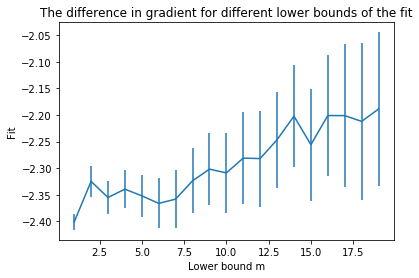

In [67]:
%matplotlib inline
plt.title('The difference in gradient for different lower bounds of the fit')
plt.xlabel('Lower bound m')
plt.ylabel('Fit')
plt.errorbar(mmins, fits, fit_errs)